In [32]:
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt

In [76]:
dict(zip(range(31),[[] for _ in range(31)]))

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: []}

In [77]:
targets=[1 for _ in range(31)]+[0 for _ in range(35)]
print(targets)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [72]:
group="Patients"#"Healthy"
data_path=join("..","NewHandPD",group,"Signal","Signal")
task_path=listdir(data_path)
task_path.sort()
counter=0
for file in task_path:#first file is `.DS_Store`
    if file[0:5]=="sigSp":
        print(int(file[-6:-4].replace("P","")))#todo use this as a dictionary key
        counter+=1
print(counter)
if group == "Patients":
    assert counter/4==31
else:
    assert counter/4==35

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
6
7
8
9
124


In [19]:
124/4

31.0

In [27]:
path=join(data_path,task_path[-1])

In [28]:
with open(path) as file:    
    for i in range(17):
        print(file.readline())
task=np.loadtxt(path, dtype=float, skiprows=17,delimiter="\t")

#<meta>

#<Person_ID_Number>201-106-271-301-508</Person_ID_Number>

#<Age>61</Age>

#<Gender>2</Gender>

#<Writing_Hand>1</Writing_Hand>

#<Weight>76</Weight>

#<Height>166</Height>

#<Smoker>1</Smoker>

#<Notice>579906</Notice>

#<Object>c_spiral</Object>

#<Object_Index>4</Object_Index>

#<Pen>Pentrics Alberich1</Pen>

#<Samplerate>1000</Samplerate>

#<Time>13:07:06</Time>

#<Date>27.06.2011</Date>

#<Comment></Comment>

#</meta>



In [29]:
task.shape

(15500, 6)

In [39]:
index2measure=["CH1: Microphone",
"CH 2: Fingergrip",
"CH 3: Axial Pressure of ink Refill",
"CH 4: Tilt and Acceleration in X direction",
"CH 5: Tilt and Acceleration in Y direction",
"CH 6: Tilt and Acceleration Z direction"]

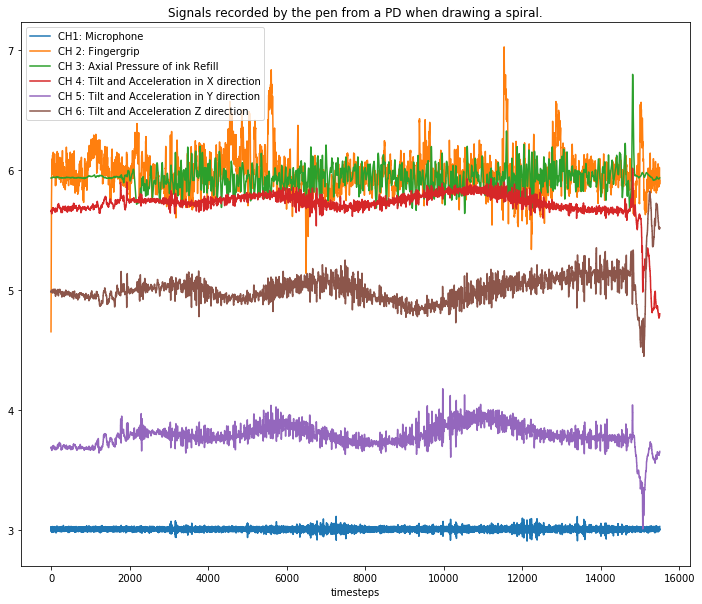

In [52]:
plt.figure(figsize=(12,10))
plt.title("Signals recorded by the pen from a PD when drawing a spiral.")
plt.xlabel("timesteps")
for i in range(6):
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

Text(0.5,1,'Tilt and Acceleration in X VS Y direction')

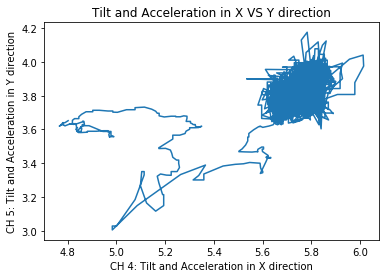

In [54]:
plt.plot(task[:,3],task[:,4])
plt.xlabel(index2measure[3])
plt.ylabel(index2measure[4])
plt.title("Tilt and Acceleration in X VS Y direction")